In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score, accuracy_score, confusion_matrix, \
classification_report, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.utils.class_weight import compute_sample_weight

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
df = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [3]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [4]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [4]:
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [7]:
df.groupby(['type','isFraud']).type.count()

type      isFraud
CASH_IN   0          1399284
CASH_OUT  0          2233384
          1             4116
DEBIT     0            41432
PAYMENT   0          2151495
TRANSFER  0           528812
          1             4097
Name: type, dtype: int64

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


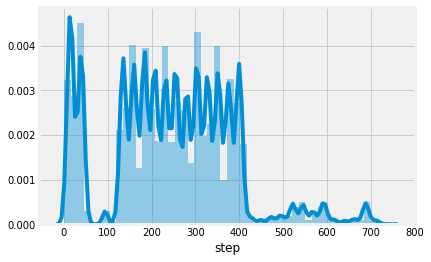

In [8]:
sns.distplot(df['step'])

In [5]:
(df.loc[df['type'] == 'CASH_OUT'].nameDest.str.contains('M')).any() # no merchants in CASH_OUT

False

In [6]:
df[(df['isFraud'] == 1) & (df['type'] =='TRANSFER')]['nameDest']\
.isin(df[(df['isFraud'] == 1) & (df['type'] =='CASH_OUT')]['nameOrig']).any()

False

In [ ]:
# ignore isFlaggedFraud, nameOrig, nameDest cols as they are not significant 

In [6]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 55
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X['type'] == 'TRANSFER', 'type'] = 0
X.loc[X['type'] == 'CASH_OUT', 'type'] = 1
X['type'] = X['type'].astype(int) # convert dtype('O') to dtype(int)

In [7]:
# only 0.3% of data is fraud

print((sum(Y) / len(Y)))

0.002964544224336551


In [8]:
# new feature !

X['errorBalanceOrig'] = X['newbalanceDest'] + X['amount'] - X['oldbalanceOrg']
X['errorBalanceDest'] = X['oldbalanceDest'] + X['amount'] - X['newbalanceDest']

In [9]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00,0.00,181.0
3,1,1,181.00,181.0,0.0,21182.0,0.00,0.00,21363.0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,265322.38,182703.5
19,1,0,215310.30,705.0,0.0,22425.0,0.00,214605.30,237735.3
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,3020023.78,-2401220.0


In [7]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (12, 8)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

Text(0.5, 1.0, 'Striped vs. homogenous fingerprints of genuine and fraudulent transactions over time')

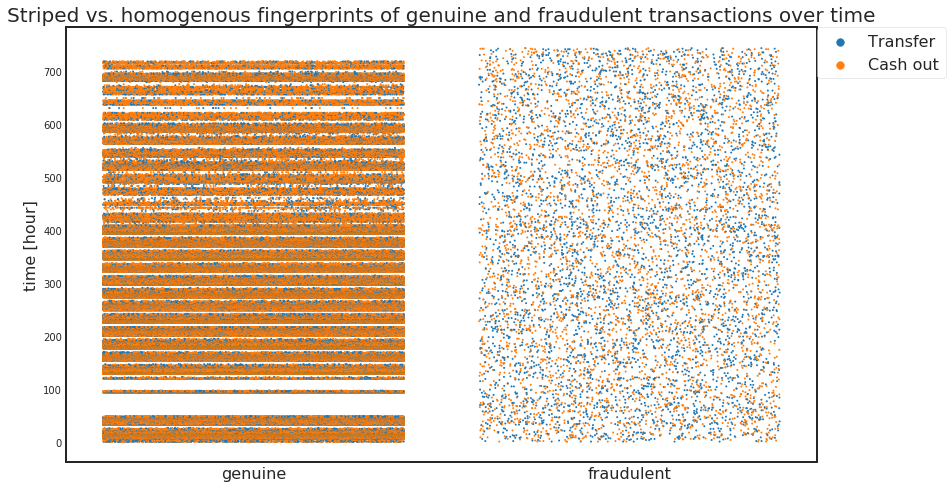

In [11]:
# fraud transactions happened across any time

limit = 3000000

ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent transactions over time', size = 20)

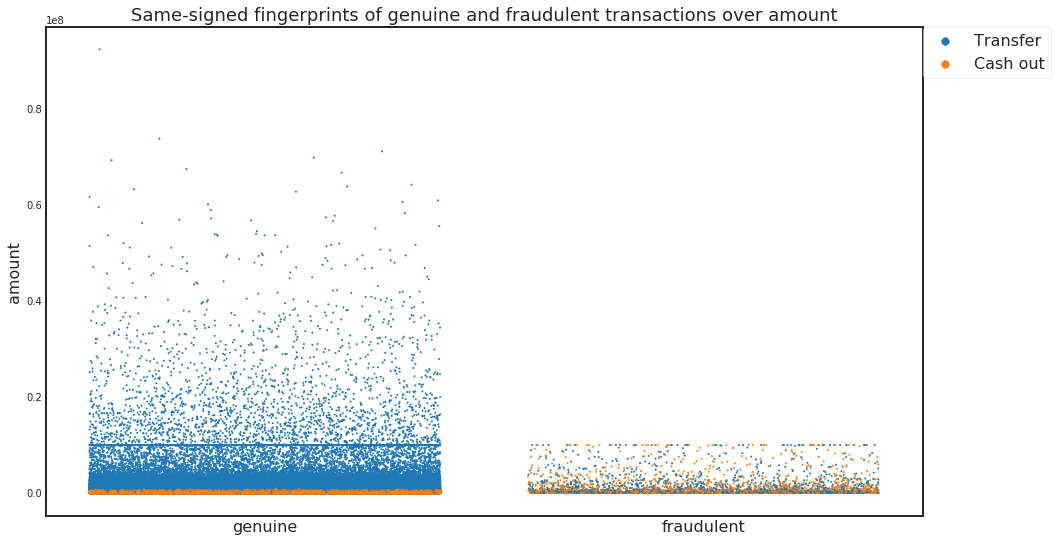

In [8]:
# 'amount' is a possible feature 

limit = 2000000

ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

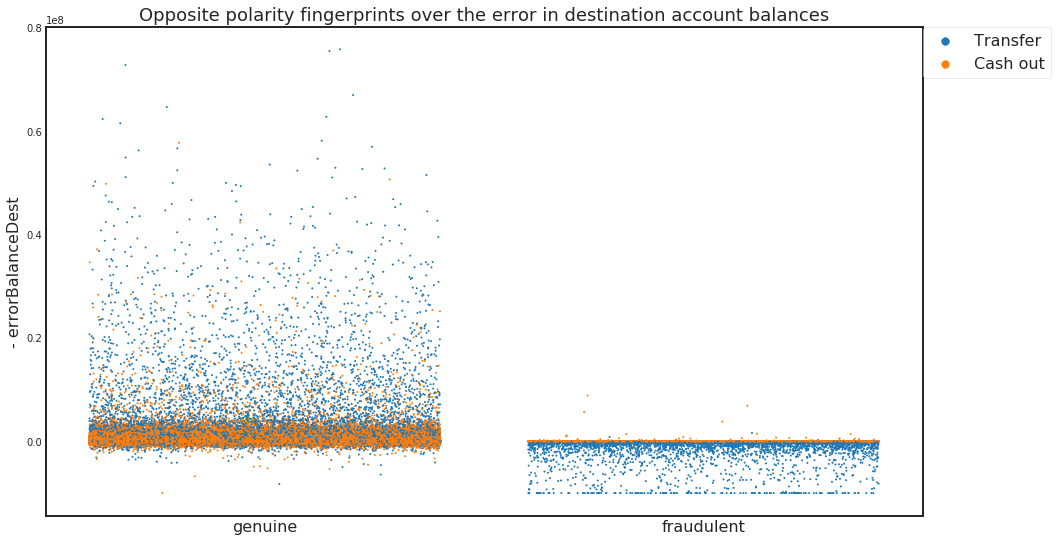

In [13]:
# new feature 'errorBalanceDest' is a strong indicator

limit = 3000000
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in destination account balances', size = 18);

### *plot correlations on continuous features* 
### *amount transferred and old account balance are strong indicators*

CPU times: user 1.19 s, sys: 358 ms, total: 1.55 s
Wall time: 1.06 s


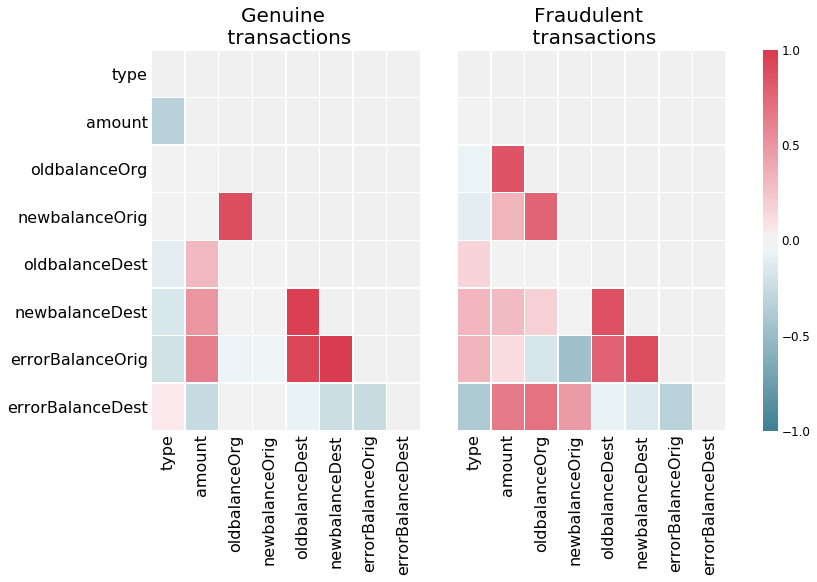

In [9]:
%%time
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, figsize = (10, 7))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 = sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16) 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16) 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16) 
ax2.set_title('Fraudulent \n transactions', size = 20)

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 12)

## classification - gradient boosted trees

In [10]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.22, \
                                                random_state = 55)

In [36]:
# %%time

# use AUPRC because data is highly skewed, only 0.3% of data is fraud
# weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())  

weights = compute_sample_weight(class_weight='balanced', y=trainY)

clf_gbm = GradientBoostingClassifier(max_depth = 3, n_estimators= 250, max_features='sqrt', verbose=1)  # n_jobs, max_feat

model_gbm = clf_gbm.fit(trainX, trainY, sample_weight=weights)

      Iter       Train Loss   Remaining Time 
         1           1.2651            5.77m
         2           1.1480            6.34m
         3           1.0546            6.19m
         4           0.9858            6.25m
         5           0.9171            5.98m
         6           0.8573            5.81m
         7           0.8030            5.92m
         8           0.7589            5.97m
         9           0.7177            5.84m
        10           0.6726            5.84m
        20           0.4258            5.65m
        30           0.3141            5.56m
        40           0.2578            5.27m
        50           0.2221            5.07m
        60           0.1954            4.79m
        70           0.1702            4.59m
        80           0.1541            4.32m
        90           0.1425            4.06m
       100           0.1341            3.80m
       200           0.0897            1.24m


In [30]:
print('AUPRC = {}'.format(average_precision_score(testY, model_gbm.predict_proba(testX)[:, 1])))

AUPRC = 0.9082315152191598


In [33]:
# %%time
predY = clf_gbm.predict(testX)
predY

array([0, 0, 0, ..., 0, 0, 0])

<function matplotlib.pyplot.show(*args, **kw)>

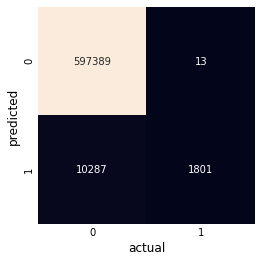

In [34]:
cm = confusion_matrix(testY, predY)

sns.heatmap(cm.T, annot=True, cbar=False, square=True, fmt='d')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show

In [35]:
# model has a high recall as they were weighted in GBM

print(classification_report(testY, predY))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    607676
           1       0.15      0.99      0.26      1814

   micro avg       0.98      0.98      0.98    609490
   macro avg       0.57      0.99      0.63    609490
weighted avg       1.00      0.98      0.99    609490



In [18]:
# accuracy metric is not accurate in this case 

print('Accuracy = {}'.format(accuracy_score(testY, predY)))

Accuracy = 0.9838569951927021


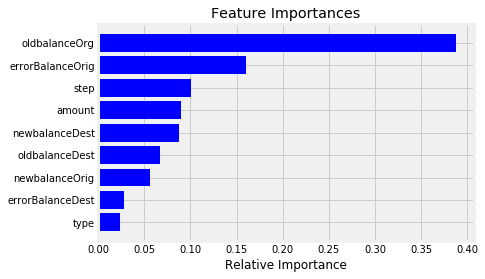

In [19]:
features = X.columns
importances = clf_gbm.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [18]:
importances

array([0.05269123, 0.01168462, 0.12216816, 0.46259086, 0.05325883,
       0.01653545, 0.04704763, 0.10948204, 0.12454118])

## classification - random forest

In [20]:
print(trainX.shape, testX.shape)

(2160919, 9) (609490, 9)


In [21]:
# %%time

# use AUPRC if data is highly skewed, only 20% of data is fraud

# weights = compute_sample_weight(class_weight='balanced', y=trainY)

clf_rf = RandomForestClassifier(max_depth=3, n_estimators= 250, max_features='sqrt', verbose=1, n_jobs=-1)  # n_jobs, max_feat

model_rf = clf_rf.fit(trainX, trainY)  # sample_weight=weights

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.6min finished


In [25]:
probabilities1 = model_rf.predict_proba(testX)
predY = model_rf.predict(testX)

print('AUPRC = {}'.format(average_precision_score(testY, probabilities1[:, 1])))
print('AUC = {}'.format(accuracy_score(testY, predY)))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.6s


AUPRC = 0.6731911818251421
AUC = 0.9983428768314493


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    2.0s finished


In [22]:
# RF model has much smaller AUPRC 

<function matplotlib.pyplot.show(*args, **kw)>

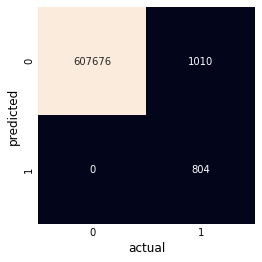

In [26]:
cm = confusion_matrix(testY, predY)

sns.heatmap(cm.T, annot=True, cbar=False, square=True, fmt='d')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show

In [27]:
print(classification_report(testY, predY))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    607676
           1       1.00      0.44      0.61      1814

   micro avg       1.00      1.00      1.00    609490
   macro avg       1.00      0.72      0.81    609490
weighted avg       1.00      1.00      1.00    609490



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    2.1s finished


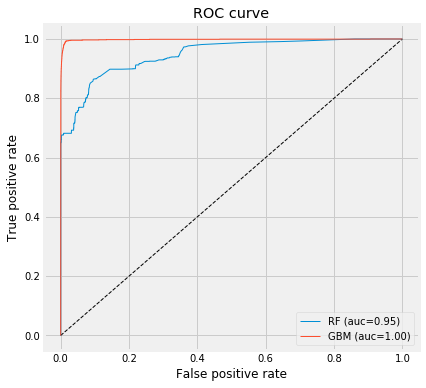

In [31]:
y_pred_rf = model_rf.predict_proba(testX)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(testY, y_pred_rf)

y_pred_gb = model_gbm.predict_proba(testX)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(testY, y_pred_gb)

fig, ax = plt.subplots(figsize=(6,6))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.plot(fpr_rf, tpr_rf, lw=1, label='RF (auc=%0.2f)'% roc_auc_score(testY, y_pred_rf))
plt.plot(fpr_gb, tpr_gb, lw=1, label='GBM (auc=%0.2f)'% roc_auc_score(testY, y_pred_gb))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

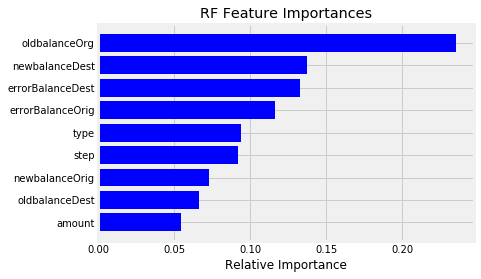

In [32]:
features = X.columns
importances = clf_rf.feature_importances_
indices = np.argsort(importances)

plt.title('RF Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()